In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Import dependencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import shutil

In [11]:
dataset_dir = "/content/drive/MyDrive/InputData"  # dataset path (contains 'healthy' and 'unhealthy' folders)
output_dir = "/content/output_data"     # Output directory for split data


In [12]:
# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [13]:
# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

In [14]:
# Function to split dataset
def split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio):
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        if len(images) < 3:
            print(f"Skipping '{class_name}' (not enough images for splitting).")
            continue

        # Perform the split
        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

        for split, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_path in split_images:
                shutil.copy(img_path, split_dir)

# Split the dataset
split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio)
print("Dataset has been successfully split into train, val, and test!")

Dataset has been successfully split into train, val, and test!


In [15]:
# Paths for training, validation, and test sets
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

In [16]:
# Parameters
img_size = (224, 224)  # EfficientNetB0 requires 224x224 image size
batch_size = 32
epochs = 10
learning_rate = 0.001

In [17]:
# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)

Found 1897 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


In [18]:
# Calculate class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.3569384835479257, 1: 0.7917362270450752}


In [19]:
# Load EfficientNetB0
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Freeze the base layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)  # First added dense layer
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)  # Second added dense layer
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)  # Third added dense layer
x = Dropout(0.3)(x)
predictions = Dense(1, activation="sigmoid")(x)  # Binary classification

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


# Add class weights to model.fit
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.6098 - loss: 0.6696 - val_accuracy: 0.6314 - val_loss: 0.6600
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6506 - loss: 0.6531 - val_accuracy: 0.6314 - val_loss: 0.6659
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.6457 - loss: 0.6612 - val_accuracy: 0.6314 - val_loss: 0.6583
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6486 - loss: 0.6541 - val_accuracy: 0.6314 - val_loss: 0.6581
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6363 - loss: 0.6616 - val_accuracy: 0.6314 - val_loss: 0.6621
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.6406 - loss: 0.6576 - val_accuracy: 0.6314 - val_loss: 0.6581
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6235 - loss: 0.6673 - val_accuracy: 0.6314 - val_loss: 0.6635
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6351 - loss: 0.6593 - val_accuracy: 0.6314 - val_loss: 0.6

In [ ]:
# Save the model
model.save("coconut_efficientnetb0_model.h5")

In [ ]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6156 - loss: 0.6662
Validation Accuracy: 63.14%


In [ ]:
# Test the model
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Found 407 images belonging to 2 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6253 - loss: 0.6612
Test Accuracy: 63.14%


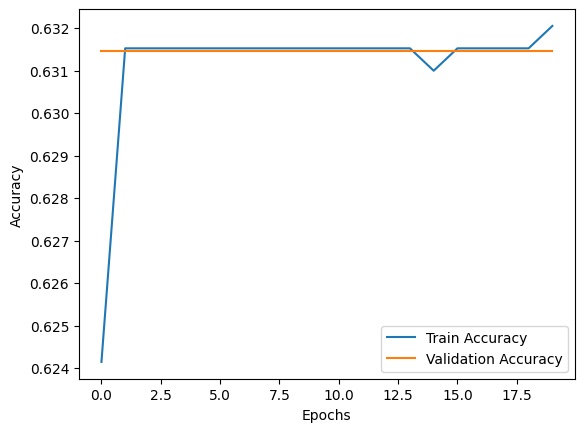

In [ ]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

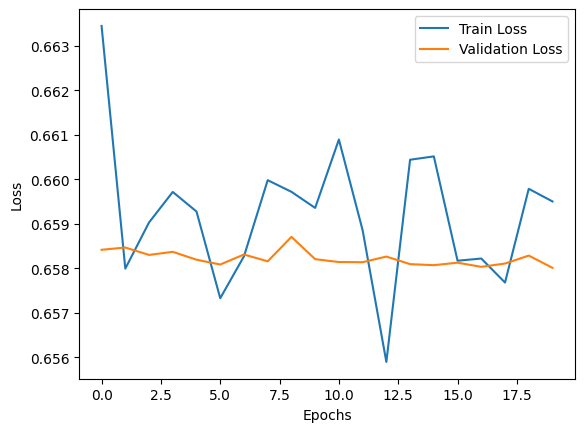

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for test set
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int)  # Binary classification threshold at 0.5

# True labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Confusion Matrix:
[[  0 150]
 [  0 257]]


In [ ]:
# Classification report
target_names = ["Healthy", "Unhealthy"]
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       150
   Unhealthy       0.63      1.00      0.77       257

    accuracy                           0.63       407
   macro avg       0.32      0.50      0.39       407
weighted avg       0.40      0.63      0.49       407



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


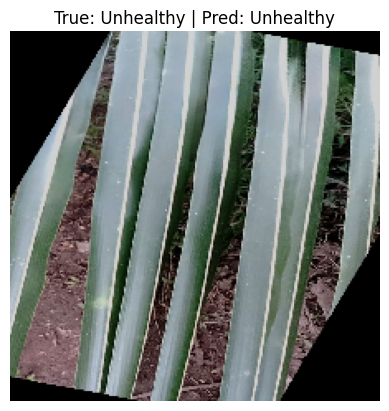

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


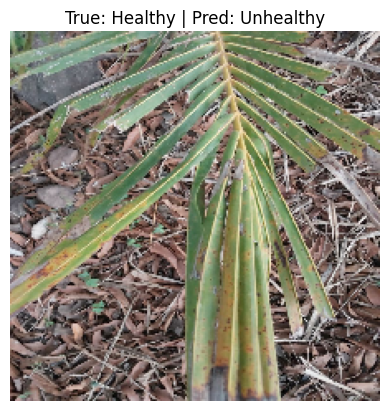

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


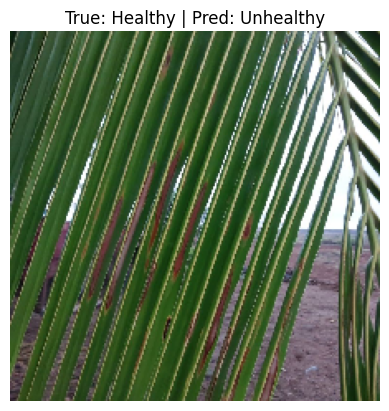

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


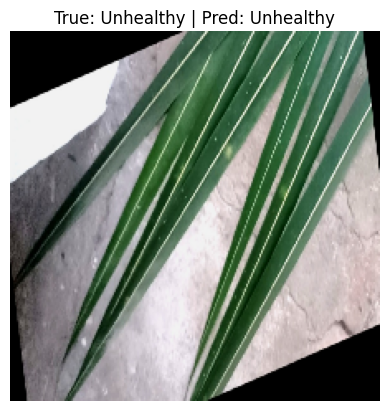

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


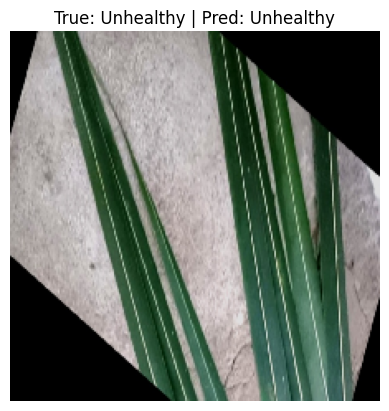

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


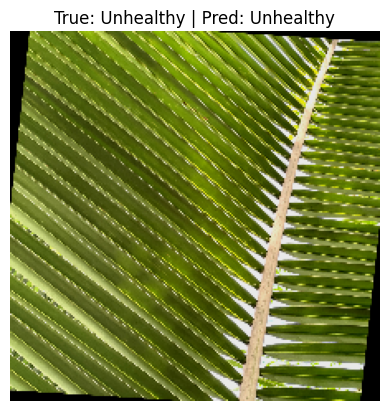

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


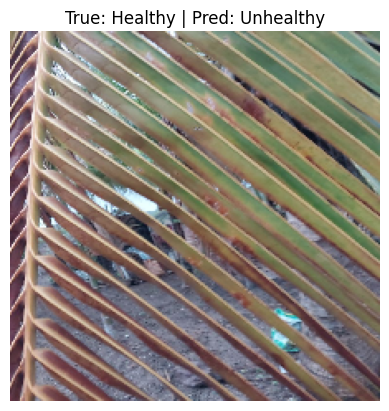

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


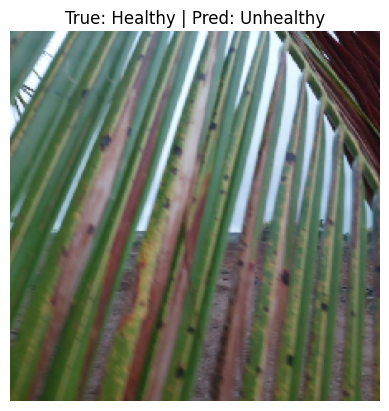

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


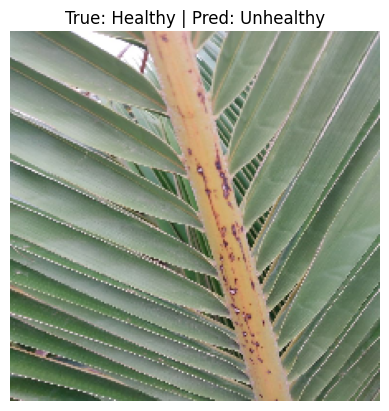

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


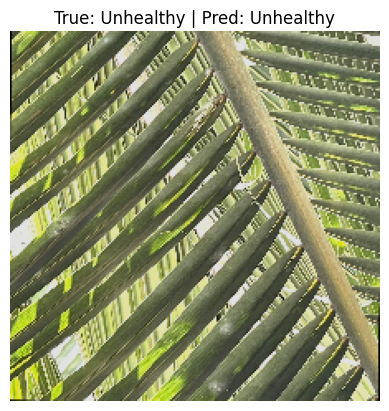

In [ ]:
# Display predictions for test images
class_labels = ["Healthy", "Unhealthy"]
for i, (img, label) in enumerate(test_generator):
    if i >= 10:  # Show only 10 images
        break
    pred = model.predict(img)
    pred_label = class_labels[int(pred[0][0] > 0.5)]
    true_label = class_labels[int(label[0])]

    plt.imshow(img[0])
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis("off")
    plt.show()